In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

/Users/1X/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
import json
from src.datasets import get_dataset
from src.modules import get_model

with open("outputs/schemes/base_1/config.json") as f:
    config = json.load(f)
dataset = get_dataset(config["dataset"])
model = get_model(config["model"], dataset.input_shape, dataset.num_classes)

model

MLP(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BernoulliDropout(std=0)
  (2): Linear(in_features=3072, out_features=100, bias=True)
  (3): ReLU()
  (4): CaptureLayer(
    (train_agg): AggregateLayer()
    (test_agg): AggregateLayer()
  )
  (5): BernoulliDropout(std=0.5)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): CaptureLayer(
    (train_agg): AggregateLayer()
    (test_agg): AggregateLayer()
  )
  (9): BernoulliDropout(std=0.5)
  (10): Linear(in_features=100, out_features=100, bias=True)
  (11): ReLU()
  (12): CaptureLayer(
    (train_agg): AggregateLayer()
    (test_agg): AggregateLayer()
  )
  (13): BernoulliDropout(std=0.5)
  (14): Linear(in_features=100, out_features=10, bias=True)
  (15): CaptureLayer(
    (train_agg): AggregateLayer()
    (test_agg): AggregateLayer()
  )
)

In [3]:
def read_df(group, tags):
    dfs = []
    for tag in tags:
        try:
            df = pd.read_json(f"outputs/{group}/{tag}_1/logs.json")
            df["tag"] = tag
            df["epoch"] = df.index + 1
            dfs.append(df)
        except:
            pass
    return pd.concat(dfs)

def agg_df(df_src, s):
    df_list = []
    for c in s:
        df = df_src.copy()
        df["tag"] = df["tag"].apply(lambda s: f"p{c}" if c in s else f"n{c}")
        df = df.groupby(["tag", "epoch"]).mean().reset_index().set_index("epoch")
        df_list.append(df)
    return pd.concat(df_list)

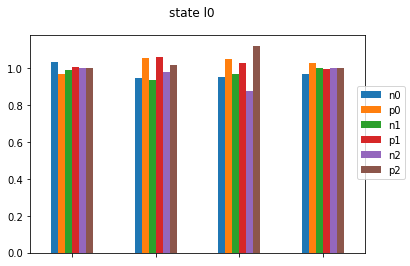

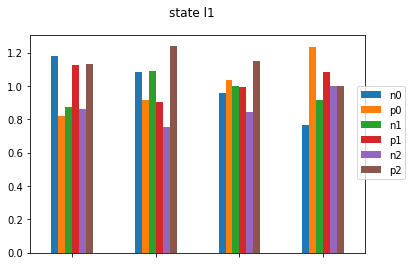

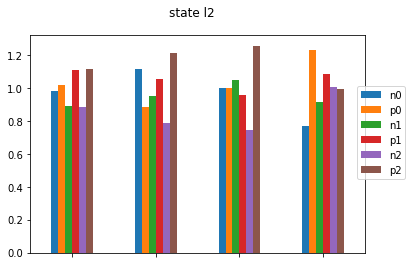

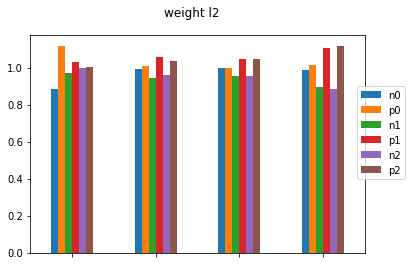

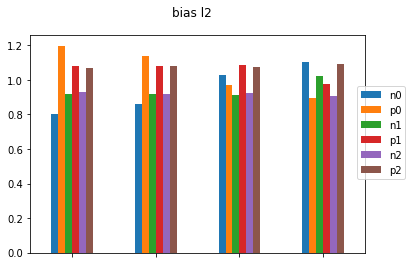

In [4]:
def barplot(df, title, epoch, labels):
    fig, ax = plt.subplots()
    df = df[df.index == epoch - 1].set_index("tag")[labels]
    df = (df / df.mean()).transpose()
    df.plot.bar(ax=ax, legend=None)
    fig.suptitle(title)
    fig.legend(loc="right")
    ax.set_xticklabels([])

#group, tags = "schemes", ("none", "base", "mean", "cov", "var", "reg")
#group, tags = "layers", ("l", "l1", "l2", "l12", "l3", "l13", "l23", "l123")
#group, tags = "mix", ("l123_a", "l123_a0", "l123_a1", "l123_a01", "l123_a2", "l123_a02", "l123_a12", "l123_a012")
group, tags = "mix", ("l_a", "l_a0", "l_a1", "l_a01", "l_a2", "l_a02", "l_a12", "l_a012")
#group, tags = "mix", ("l_a", "l_a012", "l123_a", "l123_a012")
df = read_df(group, tags)
df = agg_df(df, "012")
epoch = 50
barplot(df, "state l0", epoch, [f"eval_${i}.state.l0" for i in (4, 8, 12, 15)])
barplot(df, "state l1", epoch, [f"eval_${i}.state.l1" for i in (4, 8, 12, 15)])
barplot(df, "state l2", epoch, [f"eval_${i}.state.l2" for i in (4, 8, 12, 15)])
barplot(df, "weight l2", epoch, [f"eval_${i}.weight.l2" for i in (2, 6, 10, 14)])
barplot(df, "bias l2", epoch, [f"eval_${i}.bias.l2" for i in (2, 6, 10, 14)])

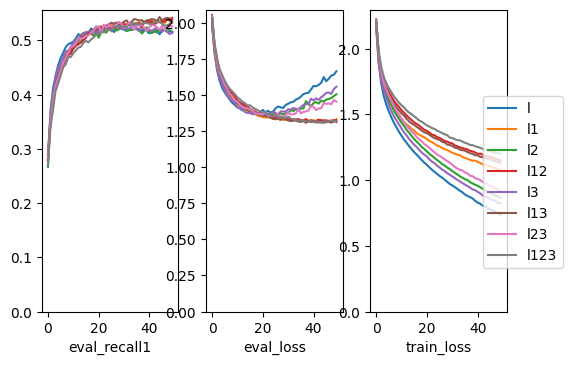

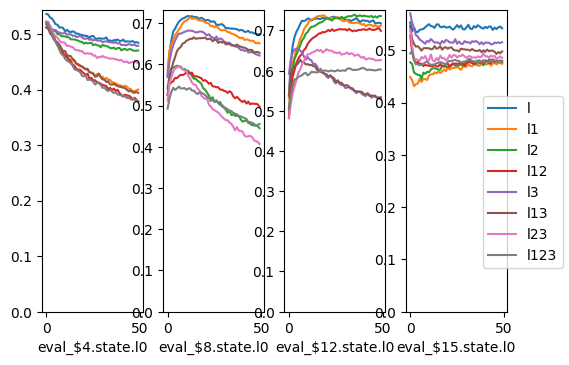

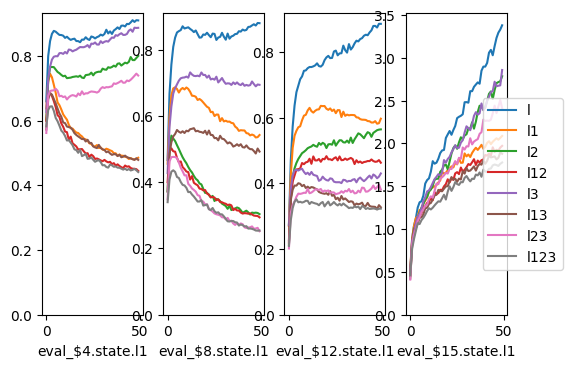

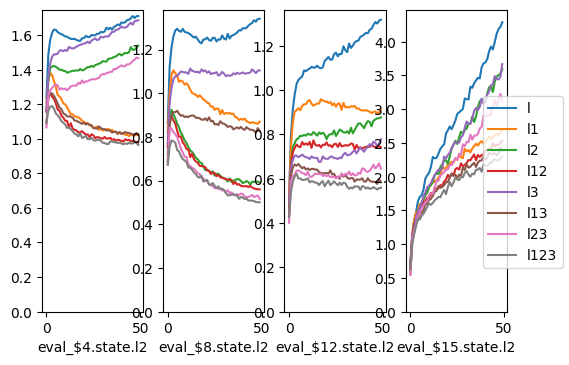

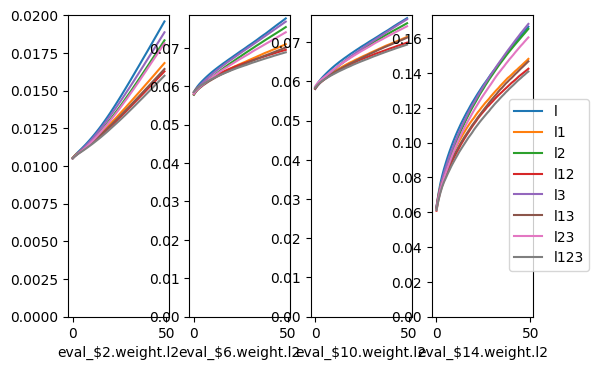

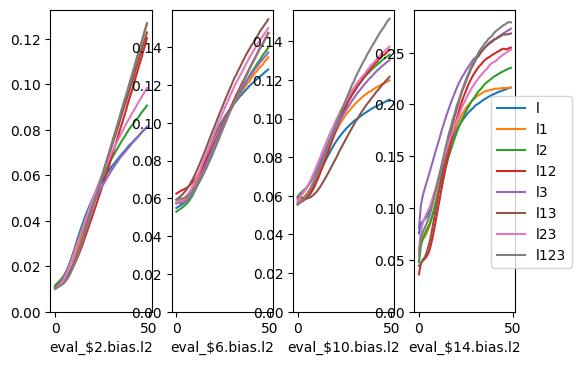

In [5]:
def rowplots(df, labels, start=0, sharex=True, sharey=False):
    fig, axes = plt.subplots(
        1, len(labels),
        sharex=sharex, sharey=sharey, 
        facecolor="w", dpi=100)
    if len(labels) == 1:
        axes = [axes]
    for ax, label in zip(axes, labels):
        df[df.index >= start].groupby("tag", sort=False)[label].plot(ax=ax)
        ax.set_xlabel(label)
        ax.set_ylim(ymin=0)
    fig.legend(*axes[0].get_legend_handles_labels(), "right")

#group, tags = "schemes", ("none", "base", "mean", "cov", "var", "reg")
group, tags = "layers", ("l", "l1", "l2", "l12", "l3", "l13", "l23", "l123")
#group, tags = "mix", ("l123_a", "l123_a0", "l123_a1", "l123_a01", "l123_a2", "l123_a02", "l123_a12", "l123_a012")
#group, tags = "mix", ("l_a", "l_a0", "l_a1", "l_a01", "l_a2", "l_a02", "l_a12", "l_a012")
#group, tags = "mix", ("l_a", "l_a012", "l123_a", "l123_a012")
df = read_df(group, tags)
#df = agg_df(df, "012")
rowplots(df, ["eval_recall1", "eval_loss", "train_loss"])
rowplots(df, [f"eval_${i}.state.l0" for i in (4, 8, 12, 15)])
rowplots(df, [f"eval_${i}.state.l1" for i in (4, 8, 12, 15)])
rowplots(df, [f"eval_${i}.state.l2" for i in (4, 8, 12, 15)])
rowplots(df, [f"eval_${i}.weight.l2" for i in (2, 6, 10, 14)])
rowplots(df, [f"eval_${i}.bias.l2" for i in (2, 6, 10, 14)])

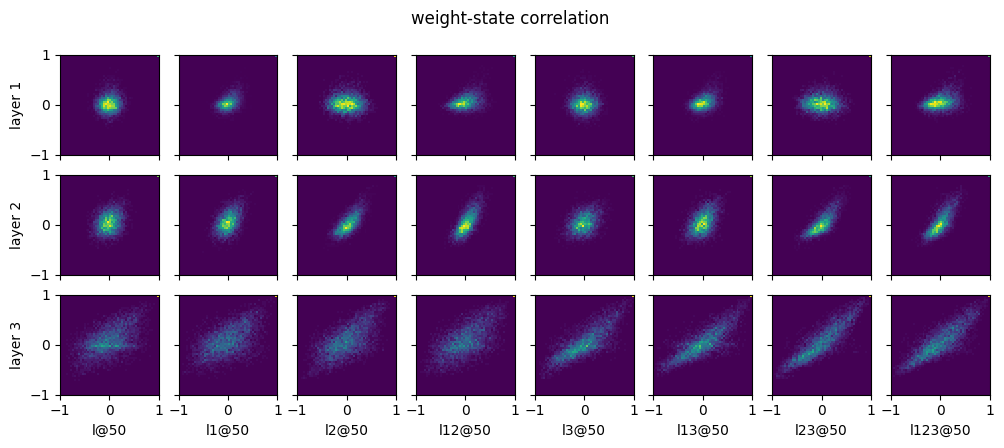

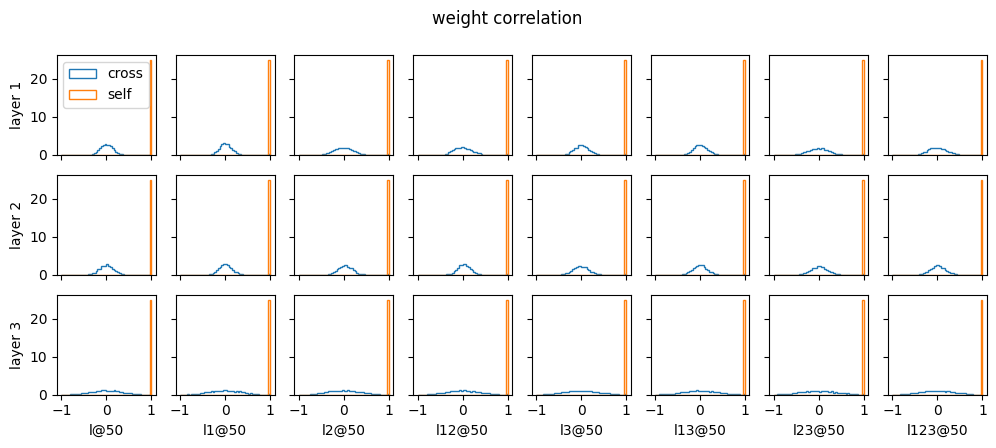

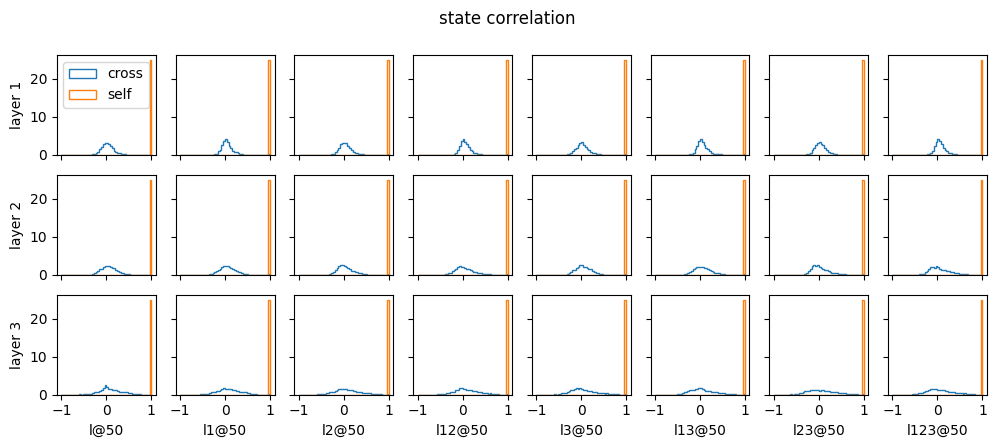

In [29]:
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def std(m1, m2):
    return (m2.diagonal() - m1.square()).clip(min=0).sqrt()

def cov(m1, m2):
    return m2 - outer(m1)

def corr(m1, m2):
    return cov(m1, m2) / outer(std(m1, m2))

def lin_map(x, s):
    return x.clamp(-s, s), (-s, s)

def inf_map(x, s):
    a = np.pi / 2
    return (x / s * a).arctan() / a, (-1, 1)

def read_state(state, i, sign):
    suffix = "p" if sign else ""
    s0 = state[f"{i}.train_agg.s0"]
    s1 = state[f"{i}.train_agg.s1{suffix}"]
    s2 = state[f"{i}.train_agg.s2{suffix}"]
    return s1 / s0, s2 / s0

def read_weight(state, i, flip):
    w = state[f"{i}.weight"]
    if flip:
        w = w.T
    return w.mean(0), w.T @ w

def gridplot(title, xlabels, ylabels):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, 
        figsize=(ncols*1.5, nrows*1.5), dpi=100, facecolor="w")
    fig.suptitle(title)
    for i in range(ncols):
        axes[nrows-1][i].set_xlabel(xlabels[i])
    for i in range(nrows):
        axes[i][0].set_ylabel(ylabels[i])
    return axes

def hist2d_plot(ax, x, y, range, bins):
    ax.hist2d(x.flatten().numpy(), y.flatten().numpy(), range=range, bins=bins)

def hist1d_plot(ax, x, range, bins):
    ax.hist(x.flatten().numpy(), label="cross", range=range, bins=bins, histtype="step", density=True)
    ax.hist(x.diagonal().numpy(), label="self", range=range, bins=bins, histtype="step", density=True)

def setplot(group, tags_epochs, layers, term, norm, scales, mapping, fn):
    xlabels = [f"{tag}@{epoch}" for tag, epoch in tags_epochs]
    ax_xy = gridplot(f"weight-state {term}", xlabels, layers)
    ax_x = gridplot(f"weight {term}", xlabels, layers)
    ax_y = gridplot(f"state {term}", xlabels, layers)
    for i, (tag, epoch) in enumerate(tags_epochs):
        state = torch.load(f"outputs/{group}/{tag}_1/checkpoint-{epoch}.pt")
        for j, layer in enumerate(layers):
            w_m1, w_m2 = read_weight(state["model"], j*4+6, False)
            s_m1, s_m2 = read_state(state["model"], j*4+4, norm)
            x, x_range = mapping(fn(w_m1, w_m2), scales[0])
            y, y_range = mapping(fn(s_m1, s_m2), scales[1])
            x_bins, y_bins = 50, 50
            hist2d_plot(ax_xy[j][i], x, y, (x_range, y_range), (x_bins, y_bins))
            hist1d_plot(ax_x[j][i], x, x_range, x_bins)
            hist1d_plot(ax_y[j][i], y, y_range, y_bins)
    ax_x[0][0].legend()
    ax_y[0][0].legend()

#group, tags, epochs = "schemes", ("none", "base", "mean", "cov", "var", "reg"), (50,)
group, tags, epochs = "layers", ("l", "l1", "l2", "l12", "l3", "l13", "l23", "l123"), (50,)
#group, tags, epochs = "mix", ("l123_a", "l123_a0", "l123_a1", "l123_a01", "l123_a2", "l123_a02", "l123_a12", "l123_a012"), (50,)
#group, tags, epochs = "mix", ("l_a", "l_a0", "l_a1", "l_a01", "l_a2", "l_a02", "l_a12", "l_a012"), (50,)
#group, tags, epochs = "mix", ("l_a", "l123_a", "l_a012", "l123_a012"), (50,)
tags_epochs = [(tag, epoch) for tag in tags for epoch in epochs]
layers = [f"layer {i+1}" for i in range(3)]

#term, norm, scales, mapping, fn = "cross-prod", False, (.5, 1.), inf_map, lambda m1, m2: m2
#term, norm, scales, mapping, fn = "covariance", False, (.5, .5), inf_map, cov
term, norm, scales, mapping, fn = "correlation", False, (1., 1.), lin_map, corr

setplot(group, tags_epochs, layers, term, norm, scales, mapping, fn)